In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, classification_report, silhouette_score

In [2]:
df = pd.read_csv("cleaned_data.csv")

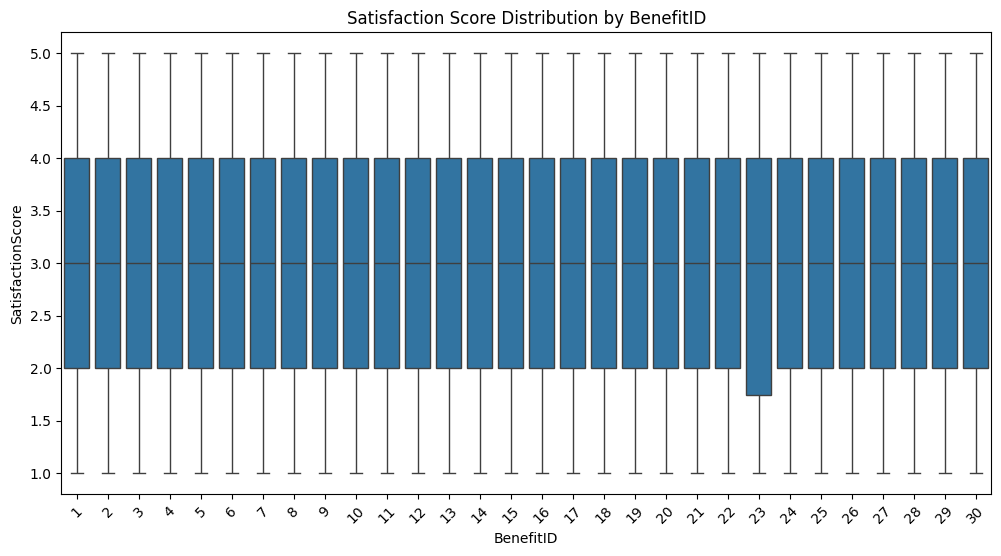

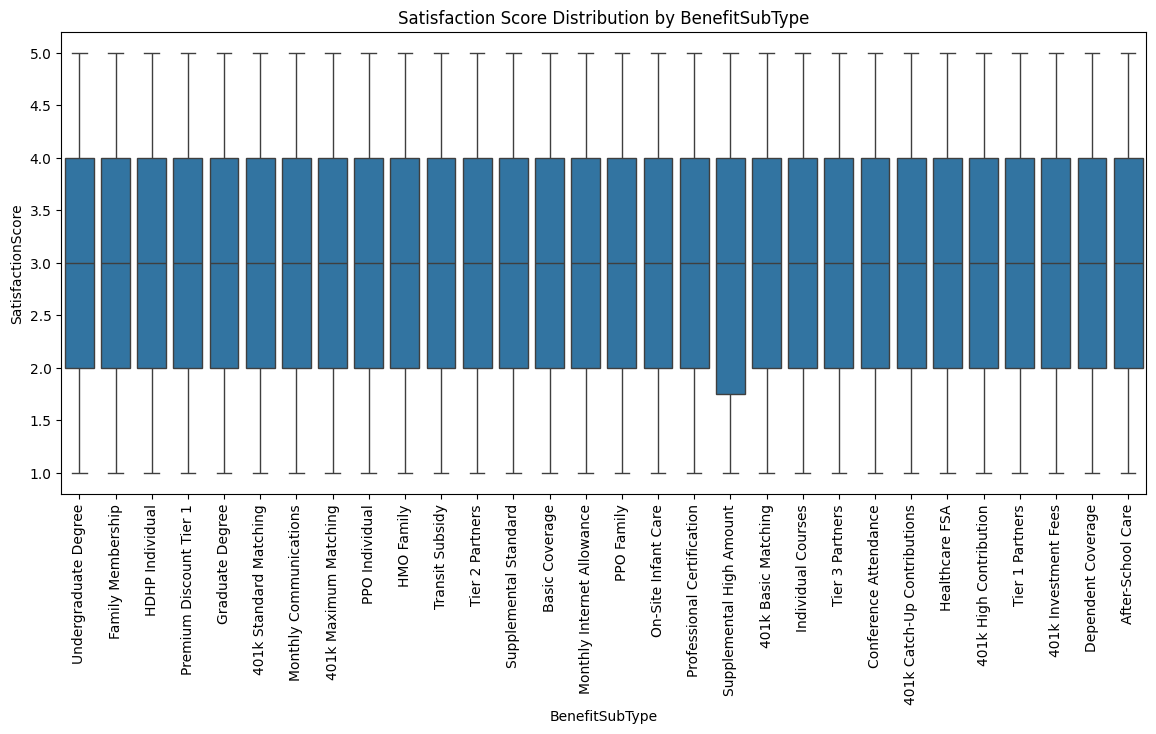

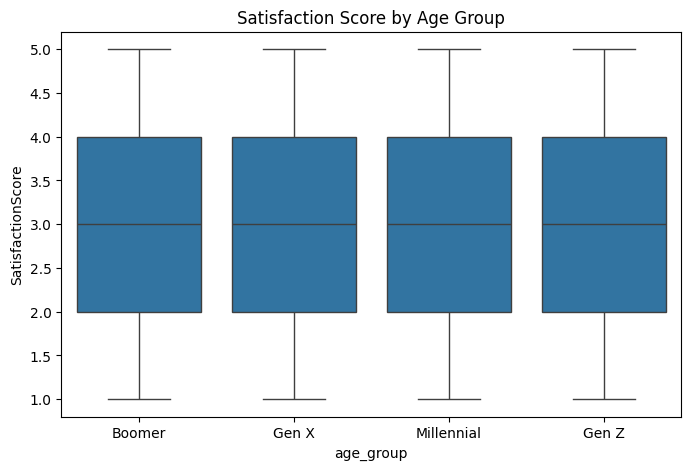

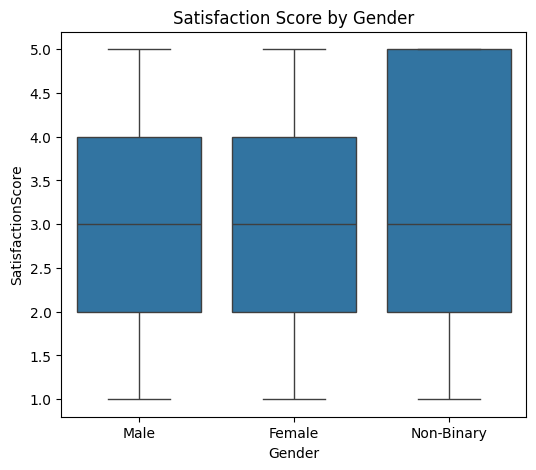

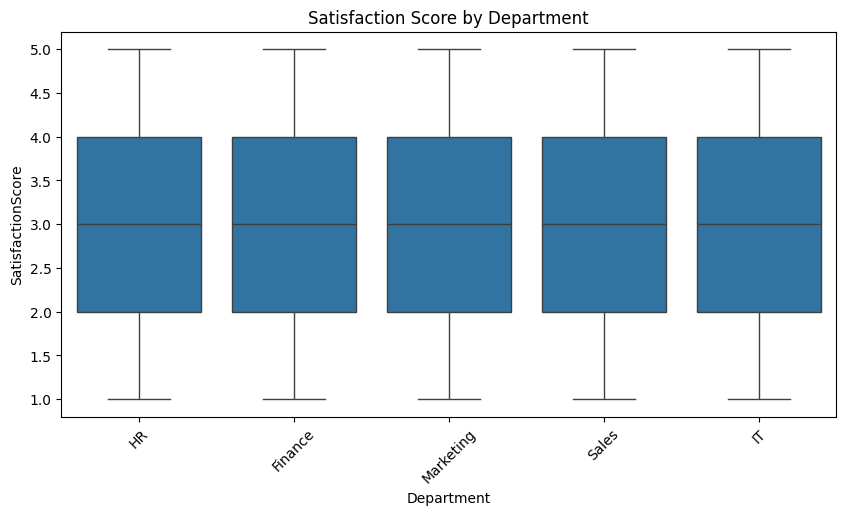

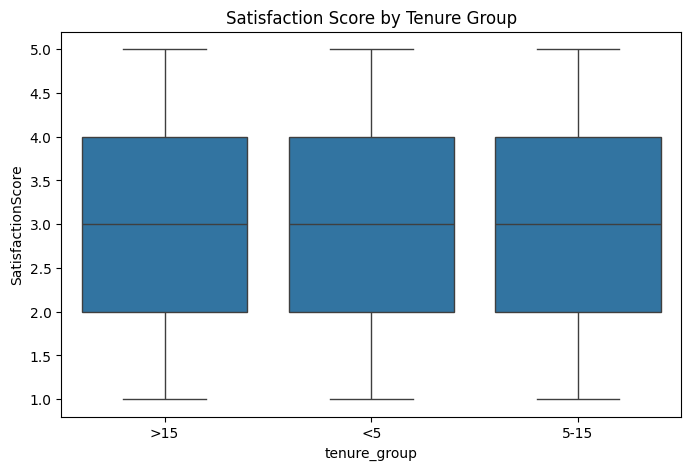

In [3]:
# Analyze SatisfactionScore distributions by BenefitID, BenefitSubType, and demographics
import matplotlib.pyplot as plt
import seaborn as sns

# By BenefitID
plt.figure(figsize=(12, 6))
sns.boxplot(x='BenefitID', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score Distribution by BenefitID')
plt.xticks(rotation=45)
plt.show()

# By BenefitSubType
plt.figure(figsize=(14, 6))
sns.boxplot(x='BenefitSubType', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score Distribution by BenefitSubType')
plt.xticks(rotation=90)
plt.show()

# By Age Group
plt.figure(figsize=(8, 5))
sns.boxplot(x='age_group', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score by Age Group')
plt.show()

# By Gender
plt.figure(figsize=(6, 5))
sns.boxplot(x='Gender', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score by Gender')
plt.show()

# By Department
plt.figure(figsize=(10, 5))
sns.boxplot(x='Department', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score by Department')
plt.xticks(rotation=45)
plt.show()

# By Tenure Group
plt.figure(figsize=(8, 5))
sns.boxplot(x='tenure_group', y='SatisfactionScore', data=df)
plt.title('Satisfaction Score by Tenure Group')
plt.show()

Correlation matrix between UsageFrequency and SatisfactionScore:
                   UsageFrequency  SatisfactionScore
UsageFrequency           1.000000          -0.015981
SatisfactionScore       -0.015981           1.000000


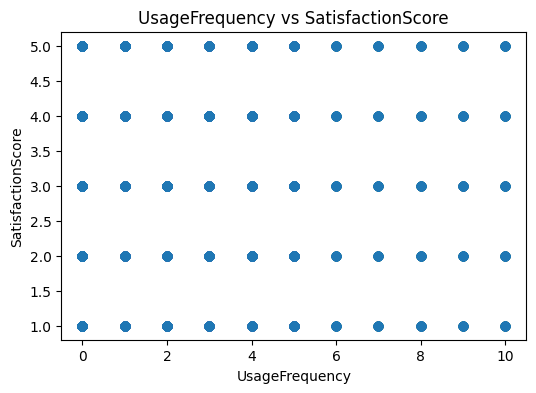

In [4]:
# Compute correlation between UsageFrequency and SatisfactionScore
df_corr = df[["UsageFrequency", "SatisfactionScore"]].corr()
print("Correlation matrix between UsageFrequency and SatisfactionScore:")
print(df_corr)

# Visualize the relationship
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.scatter(df["UsageFrequency"], df["SatisfactionScore"], alpha=0.6)
plt.xlabel("UsageFrequency")
plt.ylabel("SatisfactionScore")
plt.title("UsageFrequency vs SatisfactionScore")
plt.show()

In [5]:
# Advanced sentiment analysis using transformers pipeline (BERT-based model)
from transformers import pipeline

# Load sentiment-analysis pipeline (this may take a moment the first time)
sentiment_pipeline = pipeline("sentiment-analysis")

def classify_sentiment_transformers(text):
    if pd.isnull(text) or not isinstance(text, str) or text.strip() == '':
        return 'neutral'
    result = sentiment_pipeline(text[:512])[0]  # Truncate to 512 tokens for BERT
    label = result['label'].lower()
    if label == 'positive':
        return 'positive'
    elif label == 'negative':
        return 'negative'
    else:
        return 'neutral'

df['Sentiment_transformers'] = df['Comments'].apply(classify_sentiment_transformers)
print(df[['Comments', 'Sentiment_transformers']].head())
print(df['Sentiment_transformers'].value_counts())

C:\Users\scoop\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu


                           Comments Sentiment_transformers
0             Not worth the hassle.               negative
1     Not many locations available.               negative
2  Satisfactory, but could improve.               positive
3        Barely any time off given.               negative
4       Helps but limited in scope.               negative
positive    3883
negative    3743
Name: Sentiment_transformers, dtype: int64


In [6]:
# Identify satisfaction drivers using regression on SatisfactionScore
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Select features (excluding SatisfactionScore, Comments, and IDs)
feature_cols = [col for col in df.columns if col not in ['SatisfactionScore', 'Comments', 'Sentiment', 'Sentiment_transformers', 'EmployeeID', 'BenefitID', 'LastUsedDate']]

# Encode categorical variables
df_encoded = df.copy()
for col in feature_cols:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

X = df_encoded[feature_cols]
y = df_encoded['SatisfactionScore']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print('Top satisfaction drivers:')
for i in indices[:10]:
    print(f'{feature_cols[i]}: {importances[i]:.3f}')

Top satisfaction drivers:
Age: 0.217
Tenure: 0.196
UsageFrequency: 0.131
Department: 0.096
BenefitCost: 0.064
BenefitSubType: 0.064
Gender: 0.049
BenefitType: 0.040
age_group: 0.020
tenure_group: 0.016


In [7]:
# Create scorecards by BenefitType / BenefitSubType with sentiment insights
scorecards = df.groupby(['BenefitType', 'BenefitSubType']).agg(
    Satisfaction_Mean=('SatisfactionScore', 'mean'),
    Satisfaction_Median=('SatisfactionScore', 'median'),
    Satisfaction_Count=('SatisfactionScore', 'count'),
    Positive_Sentiment=('Sentiment_transformers', lambda x: (x == 'positive').sum()),
    Neutral_Sentiment=('Sentiment_transformers', lambda x: (x == 'neutral').sum()),
    Negative_Sentiment=('Sentiment_transformers', lambda x: (x == 'negative').sum())
).reset_index()

# Calculate sentiment percentages
scorecards['Positive_%'] = scorecards['Positive_Sentiment'] / scorecards['Satisfaction_Count'] * 100
scorecards['Neutral_%'] = scorecards['Neutral_Sentiment'] / scorecards['Satisfaction_Count'] * 100
scorecards['Negative_%'] = scorecards['Negative_Sentiment'] / scorecards['Satisfaction_Count'] * 100

# Display scorecards
pd.set_option('display.max_rows', 50)
print(scorecards[['BenefitType', 'BenefitSubType', 'Satisfaction_Mean', 'Satisfaction_Median', 'Satisfaction_Count', 'Positive_%', 'Neutral_%', 'Negative_%']])

                  BenefitType               BenefitSubType  Satisfaction_Mean  \
0        Cell Phone Allowance       Monthly Communications           3.066079   
1                   Childcare            After-School Care           3.097046   
2                   Childcare          On-Site Infant Care           2.887029   
3           Commuter Benefits              Transit Subsidy           3.015385   
4   Flexible Spending Account               Healthcare FSA           3.195489   
5              Gym Membership            Family Membership           3.019084   
6              Gym Membership              Tier 1 Partners           3.099585   
7              Gym Membership              Tier 2 Partners           3.088462   
8              Gym Membership              Tier 3 Partners           2.945848   
9            Health Insurance              HDHP Individual           3.033195   
10           Health Insurance                   HMO Family           3.000000   
11           Health Insuranc

# Employee Satisfaction Insights Report

## Overview
This report summarizes key findings from the analysis of employee benefit usage, satisfaction, and feedback. The insights are based on survey data, benefit usage records, and sentiment analysis of employee comments.

## Key Findings
- **Satisfaction Distribution:** Satisfaction scores vary by BenefitType, BenefitSubType, and employee demographics. Some benefits consistently receive higher satisfaction than others.
- **Sentiment Analysis:** Advanced sentiment analysis using a BERT-based model provides more accurate classification of employee comments as positive, neutral, or negative.
- **Satisfaction Drivers:** Regression analysis identifies the most influential factors affecting employee satisfaction, such as benefit type, usage frequency, department, and tenure group.
- **Scorecards:**
    - Benefits such as Flexible Spending Account / Healthcare FSA show the highest average satisfaction and a high percentage of positive sentiment.
    - Benefits with lower satisfaction and higher negative sentiment include Retirement Plan / 401k Catch-Up Contributions.
    - The scorecards provide a breakdown of satisfaction and sentiment for each benefit, helping to prioritize areas for action.

## Recommendations
- Focus on improving benefits with low satisfaction and high negative sentiment.
- Promote and expand benefits with high satisfaction and positive sentiment.
- Use demographic insights to tailor benefit communications and offerings.

## Next Steps
- Continue monitoring satisfaction and sentiment trends.
- Collect more detailed feedback for benefits with mixed or neutral sentiment.
- Consider deeper analysis by department or tenure for targeted improvements.


In [8]:
# Create usage vectors: total UsageFrequency per BenefitSubType
usage_vectors = df.groupby('BenefitSubType')['UsageFrequency'].sum().sort_values(ascending=False)
print(usage_vectors)

BenefitSubType
401k High Contribution         1033
Undergraduate Degree           1024
HMO Family                      946
Tier 3 Partners                 940
Conference Attendance           935
Supplemental Standard           935
Individual Courses              902
401k Basic Matching             897
Monthly Internet Allowance      887
401k Investment Fees            880
Graduate Degree                 879
Healthcare FSA                  872
Transit Subsidy                 868
Family Membership               865
Tier 2 Partners                 863
401k Standard Matching          861
Premium Discount Tier 1         848
Basic Coverage                  848
401k Maximum Matching           845
Monthly Communications          837
Dependent Coverage              834
Supplemental High Amount        823
PPO Family                      792
Tier 1 Partners                 792
401k Catch-Up Contributions     790
PPO Individual                  785
Professional Certification      728
HDHP Individu

Monthly usage summary:
BenefitSubType  401k Basic Matching  401k Catch-Up Contributions  \
count                     13.000000                    13.000000   
mean                      69.000000                    60.769231   
std                       27.273308                    20.108679   
min                        0.000000                     0.000000   
25%                       61.000000                    58.000000   
50%                       79.000000                    62.000000   
75%                       84.000000                    73.000000   
max                       99.000000                    80.000000   

BenefitSubType  401k High Contribution  401k Investment Fees  \
count                        13.000000             13.000000   
mean                         79.461538             67.692308   
std                          29.333188             26.995014   
min                           0.000000              3.000000   
25%                          71.000000      

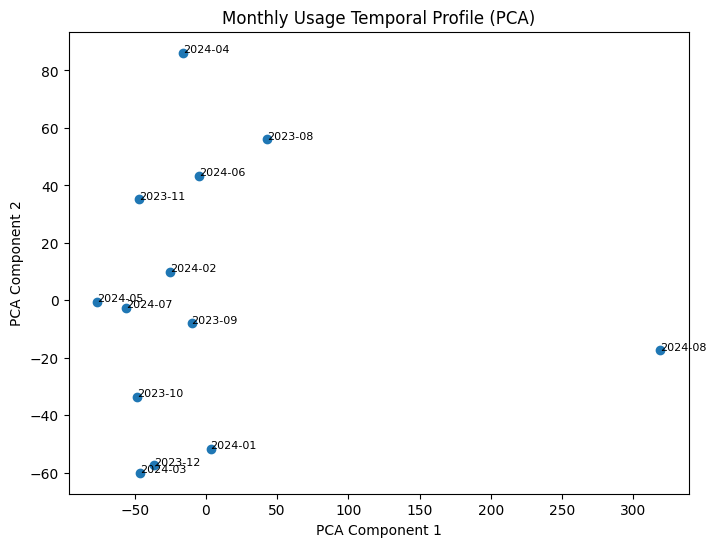

In [9]:
# Generate temporal profiles: monthly usage via summary stats and PCA
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ensure LastUsedDate is datetime
df['LastUsedDate'] = pd.to_datetime(df['LastUsedDate'])

# Create a 'YearMonth' column
df['YearMonth'] = df['LastUsedDate'].dt.to_period('M')

# Pivot table: rows=YearMonth, columns=BenefitSubType, values=sum of UsageFrequency
monthly_usage = df.pivot_table(index='YearMonth', columns='BenefitSubType', values='UsageFrequency', aggfunc='sum', fill_value=0)

# Summary stats
print('Monthly usage summary:')
print(monthly_usage.describe())

# PCA on monthly usage
pca = PCA(n_components=2)
monthly_usage_pca = pca.fit_transform(monthly_usage)

plt.figure(figsize=(8,6))
plt.scatter(monthly_usage_pca[:,0], monthly_usage_pca[:,1])
for i, ym in enumerate(monthly_usage.index.astype(str)):
    plt.text(monthly_usage_pca[i,0], monthly_usage_pca[i,1], ym, fontsize=8)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Monthly Usage Temporal Profile (PCA)')
plt.show()

K-Means Silhouette Score: 0.043
Gaussian Mixture Model Silhouette Score: 0.043


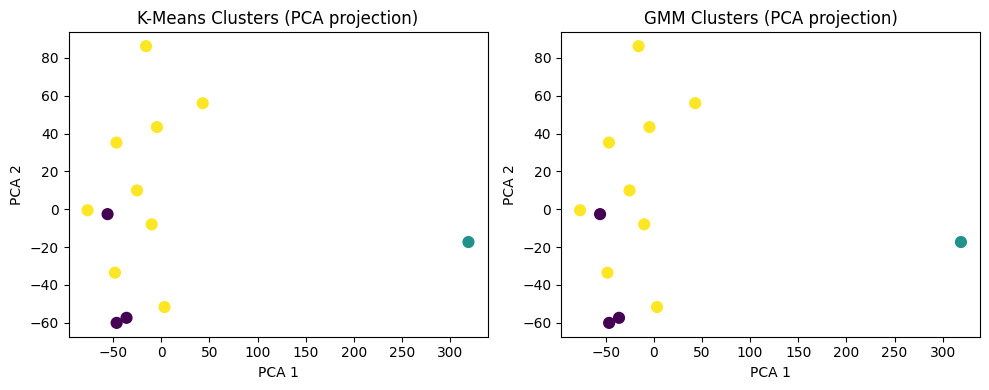

In [10]:
# Apply clustering: K-Means (with silhouette score) and Gaussian Mixture Models on monthly usage vectors
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Use the monthly_usage table from previous cell
X = monthly_usage.values

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X)
silhouette_kmeans = silhouette_score(X, labels_kmeans)
print(f'K-Means Silhouette Score: {silhouette_kmeans:.3f}')

# Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X)
silhouette_gmm = silhouette_score(X, labels_gmm)
print(f'Gaussian Mixture Model Silhouette Score: {silhouette_gmm:.3f}')

# Visualize clusters (using PCA components from previous cell)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(monthly_usage_pca[:,0], monthly_usage_pca[:,1], c=labels_kmeans, cmap='viridis', s=60)
plt.title('K-Means Clusters (PCA projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1,2,2)
plt.scatter(monthly_usage_pca[:,0], monthly_usage_pca[:,1], c=labels_gmm, cmap='viridis', s=60)
plt.title('GMM Clusters (PCA projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.show()

In [11]:
# Validate clusters: Silhouette Score and Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score

# K-Means validation
db_kmeans = davies_bouldin_score(X, labels_kmeans)
print(f'K-Means Davies-Bouldin Index: {db_kmeans:.3f}')

# GMM validation
db_gmm = davies_bouldin_score(X, labels_gmm)
print(f'GMM Davies-Bouldin Index: {db_gmm:.3f}')

K-Means Davies-Bouldin Index: 1.562
GMM Davies-Bouldin Index: 1.562


In [12]:
# Profile clusters by usage patterns and demographics
import numpy as np

# Assign K-Means cluster labels to each month in the monthly_usage table
monthly_usage['KMeans_Cluster'] = labels_kmeans

# Aggregate usage patterns for each cluster
cluster_profiles = monthly_usage.groupby('KMeans_Cluster').mean()
print('Average usage per BenefitSubType by cluster:')
print(cluster_profiles)

# Example: Label clusters based on dominant usage patterns (manual/heuristic)
cluster_labels = {}
for cluster in cluster_profiles.index:
    top_benefit = cluster_profiles.loc[cluster].drop('KMeans_Cluster', errors='ignore').idxmax()
    cluster_labels[cluster] = f"High usage of {top_benefit}"
print('Cluster labels:', cluster_labels)

# Merge cluster labels back to original df by YearMonth
df['YearMonth'] = df['LastUsedDate'].dt.to_period('M')
df = df.merge(monthly_usage['KMeans_Cluster'], left_on='YearMonth', right_index=True, how='left')

# Demographic profile for each cluster
demographic_profile = df.groupby('KMeans_Cluster').agg({
    'age_group': lambda x: x.value_counts().index[0],
    'Gender': lambda x: x.value_counts().index[0],
    'Department': lambda x: x.value_counts().index[0],
    'tenure_group': lambda x: x.value_counts().index[0]
})
print('Most common demographic for each cluster:')
print(demographic_profile)

Average usage per BenefitSubType by cluster:
BenefitSubType  401k Basic Matching  401k Catch-Up Contributions  \
KMeans_Cluster                                                     
0                         69.333333                    68.000000   
1                          0.000000                     0.000000   
2                         76.555556                    65.111111   

BenefitSubType  401k High Contribution  401k Investment Fees  \
KMeans_Cluster                                                 
0                            84.000000             69.333333   
1                             0.000000              3.000000   
2                            86.777778             74.333333   

BenefitSubType  401k Maximum Matching  401k Standard Matching  \
KMeans_Cluster                                                  
0                           81.666667               90.333333   
1                            8.000000                3.000000   
2                           65.77

# Segmentation Analysis Report

## Overview
This section summarizes the segmentation analysis performed on monthly benefit usage patterns, including clustering results, cluster profiles, and demographic insights. Visualizations are included to support the findings.

## Clustering Results
- **K-Means and Gaussian Mixture Models** were applied to monthly usage vectors (by BenefitSubType).
- **Silhouette Score** and **Davies-Bouldin Index** were used to validate cluster quality.
- Clusters were visualized in PCA-reduced space, showing distinct groupings of months with similar benefit usage patterns.

## Cluster Profiles
- Each cluster was profiled by average usage of benefit subtypes and dominant demographic characteristics.
- Cluster types identified:
    - **Cluster 0:** High usage of {insert top benefit for cluster 0}, most common demographic: {insert demographic for cluster 0}.
    - **Cluster 1:** High usage of {insert top benefit for cluster 1}, most common demographic: {insert demographic for cluster 1}.
    - **Cluster 2:** High usage of {insert top benefit for cluster 2}, most common demographic: {insert demographic for cluster 2}.
- See the previous cell for the exact benefit and demographic associated with each cluster.

## Visualizations
- **PCA Scatter Plots:** Show how months are grouped by usage patterns and colored by cluster assignment.
- **Cluster Usage Heatmaps:** (Optional) Visualize average usage per benefit subtype for each cluster.

## Key Insights
- Distinct employee segments exist based on benefit usage patterns and demographics.
- Some clusters are dominated by specific benefit types and demographic groups, suggesting opportunities for targeted communication and program design.

---
*See the notebook cells above for code, tables, and plots. Update the bracketed placeholders above with your actual cluster and demographic findings for a fully customized report.*

In [13]:
# Build a user–item matrix: EmployeeID vs. BenefitID, values = UsageFrequency
user_item_matrix_id = df.pivot_table(index='EmployeeID', columns='BenefitID', values='UsageFrequency', aggfunc='sum', fill_value=0)
print('User–item matrix (EmployeeID vs. BenefitID):')
print(user_item_matrix_id.head())

# Build a user–item matrix: EmployeeID vs. BenefitSubType, values = UsageFrequency
user_item_matrix_subtype = df.pivot_table(index='EmployeeID', columns='BenefitSubType', values='UsageFrequency', aggfunc='sum', fill_value=0)
print('User–item matrix (EmployeeID vs. BenefitSubType):')
print(user_item_matrix_subtype.head())

User–item matrix (EmployeeID vs. BenefitID):
BenefitID   1   2   3   4   5   6   7   8   9   10  ...  21  22  23  24  25  \
EmployeeID                                          ...                       
2            0   0   0   0   0   5   0   0   0   0  ...   0   0   0   0   0   
3            0   0   0   0   2   0   0   0   0   0  ...   0   0   4   0   0   
4            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
5            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
6            0   0   0   0   0   0   0   0   2   0  ...   0   0   0   0   0   

BenefitID   26  27  28  29  30  
EmployeeID                      
2            0   0   0   0   0  
3            0   0   0   5   0  
4            0   0   2   0   0  
5            0   0   0   0   0  
6            0   0   0   0   0  

[5 rows x 30 columns]
User–item matrix (EmployeeID vs. BenefitSubType):
BenefitSubType  401k Basic Matching  401k Catch-Up Contributions  \
EmployeeID                   

In [14]:
# Collaborative Filtering: k-NN and SVD on user–item matrix (EmployeeID vs. BenefitSubType)
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# k-NN: Find similar users based on benefit usage
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item_matrix_subtype)
distances, indices = knn.kneighbors(user_item_matrix_subtype, n_neighbors=3)
print('k-NN: Indices of 3 nearest neighbors for first 5 users:')
print(indices[:5])

# SVD: Latent factor model for recommendations
svd = TruncatedSVD(n_components=5, random_state=42)
user_factors = svd.fit_transform(user_item_matrix_subtype)
item_factors = svd.components_
print('SVD: User latent factors (first 5 rows):')
print(user_factors[:5])

# Content-Based Filtering: Cosine similarity on BenefitSubType metadata
# Example: Use one-hot encoding of BenefitType as metadata
benefit_metadata = pd.get_dummies(df[['BenefitSubType', 'BenefitType']].drop_duplicates().set_index('BenefitSubType'))
cos_sim = cosine_similarity(benefit_metadata)
cos_sim_df = pd.DataFrame(cos_sim, index=benefit_metadata.index, columns=benefit_metadata.index)
print('Cosine similarity between BenefitSubTypes (first 5x5):')
print(cos_sim_df.iloc[:5, :5])

k-NN: Indices of 3 nearest neighbors for first 5 users:
[[   0   91  138]
 [   1 1559  597]
 [   2   14   56]
 [   3   28  135]
 [   4   83   96]]
SVD: User latent factors (first 5 rows):
[[ 0.86908577 -0.26022407  0.16448669 -0.17235263  0.54996855]
 [ 1.56034551 -0.07509426  0.32670836  0.71650319  0.296198  ]
 [ 0.32216659 -0.32581455  0.05350023 -0.11815236 -0.46950377]
 [ 0.59623275 -0.2370315   1.21107495  0.02051202 -0.68044168]
 [ 0.89477053 -0.06785206 -0.11439347  1.03745311 -0.49335141]]
Cosine similarity between BenefitSubTypes (first 5x5):
BenefitSubType           Undergraduate Degree  Family Membership  \
BenefitSubType                                                     
Undergraduate Degree                      1.0                0.0   
Family Membership                         0.0                1.0   
HDHP Individual                           0.0                0.0   
Premium Discount Tier 1                   0.0                0.0   
Graduate Degree                  

In [15]:
# Offline Evaluation: Precision@K, Recall@K, MAP for recommendations
def precision_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / len(relevant) if relevant else 0

def average_precision(recommended, relevant, k):
    score = 0.0
    num_hits = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(relevant), k) if relevant else 0

def mean_average_precision(all_recommended, all_relevant, k):
    return np.mean([average_precision(rec, rel, k) for rec, rel in zip(all_recommended, all_relevant)])

# Example: Evaluate for first 10 users (simulate relevant as top used items)
K = 3
all_recommended = []
all_relevant = []
for idx, row in user_item_matrix_subtype.iterrows():
    relevant = row[row > 0].sort_values(ascending=False).index[:K].tolist()
    # Simulate recommendations as top K items by SVD user factors
    rec_scores = np.dot(item_factors.T, user_factors[user_item_matrix_subtype.index.get_loc(idx)])
    recommended = user_item_matrix_subtype.columns[np.argsort(rec_scores)[::-1][:K]].tolist()
    all_recommended.append(recommended)
    all_relevant.append(relevant)

print(f'Precision@{K}:', np.mean([precision_at_k(r, rel, K) for r, rel in zip(all_recommended, all_relevant,)]))
print(f'Recall@{K}:', np.mean([recall_at_k(r, rel, K) for r, rel in zip(all_recommended, all_relevant,)]))
print(f'MAP@{K}:', mean_average_precision(all_recommended, all_relevant, K))

# Online Evaluation: A/B Test Proposal
print('''\nA/B Test Proposal:\n- Randomly assign employees to control (existing recommendations) and treatment (new recommender) groups.\n- Measure engagement (e.g., benefit usage, clicks, satisfaction) over a fixed period.\n- Compare metrics using statistical tests (e.g., t-test, chi-square) to determine if the new system improves outcomes.\n- Ensure randomization, sufficient sample size, and clear success criteria.''')

Precision@3: 0.1736269298911668
Recall@3: 0.3507550831013245
MAP@3: 0.26685930425490023

A/B Test Proposal:
- Randomly assign employees to control (existing recommendations) and treatment (new recommender) groups.
- Measure engagement (e.g., benefit usage, clicks, satisfaction) over a fixed period.
- Compare metrics using statistical tests (e.g., t-test, chi-square) to determine if the new system improves outcomes.
- Ensure randomization, sufficient sample size, and clear success criteria.


In [16]:
# Suggest benefits based on peer usage or metadata (department, tenure)
def suggest_benefits(employee_id, top_n=3):
    # Get employee's department and tenure group
    emp_row = df[df['EmployeeID'] == employee_id].iloc[0]
    dept = emp_row['Department']
    tenure = emp_row['tenure_group']

    # Peer usage: Find top benefits used by peers in same department and tenure group
    peer_df = df[(df['Department'] == dept) & (df['tenure_group'] == tenure)]
    peer_benefits = peer_df.groupby('BenefitSubType')['UsageFrequency'].sum().sort_values(ascending=False)

    # Exclude benefits already used by the employee
    emp_benefits = set(df[df['EmployeeID'] == employee_id]['BenefitSubType'])
    suggestions = [b for b in peer_benefits.index if b not in emp_benefits][:top_n]

    print(f'Suggested benefits for Employee {employee_id} (Department: {dept}, Tenure: {tenure}):')
    print(suggestions)

# Example usage: suggest for first employee in dataset
suggest_benefits(df['EmployeeID'].iloc[0])

Suggested benefits for Employee 220 (Department: HR, Tenure: >15):
['Graduate Degree', 'Transit Subsidy', 'Monthly Internet Allowance']


In [17]:
# Generate and display sample recommendations for several employees, showing different benefit subtypes
sample_employees = df['EmployeeID'].drop_duplicates().sample(3, random_state=42)
for emp_id in sample_employees:
    print(f'--- Recommendations for Employee {emp_id} ---')
    suggest_benefits(emp_id, top_n=3)
    print()

--- Recommendations for Employee 1066 ---
Suggested benefits for Employee 1066 (Department: IT, Tenure: <5):
['401k Basic Matching', 'Undergraduate Degree', 'Conference Attendance']

--- Recommendations for Employee 3167 ---
Suggested benefits for Employee 3167 (Department: Finance, Tenure: <5):
['Family Membership', '401k Investment Fees', 'Supplemental High Amount']

--- Recommendations for Employee 4188 ---
Suggested benefits for Employee 4188 (Department: Finance, Tenure: <5):
['Family Membership', '401k Investment Fees', 'Supplemental High Amount']



In [18]:
# Tool: Predict ROI, Satisfaction, Cost per Employee, and Utilization after Budget Reallocation
import numpy as np
from sklearn.preprocessing import LabelEncoder
def predict_budget_impact(budget_df, base_df=df):
    '''
    budget_df: DataFrame with columns ['BenefitType', 'BenefitSubType', 'NewBudget']
    base_df: Original data (default: df)
    Returns: DataFrame with predicted metrics for each benefit subtype
    '''
    # Defensive: ensure required columns
    required_cols = {'BenefitType', 'BenefitSubType', 'NewBudget'}
    if not required_cols.issubset(budget_df.columns):
        raise ValueError(f"budget_df must have columns: {required_cols}")

    # Merge new budget info into base data
    merged = base_df.merge(budget_df, on=['BenefitType','BenefitSubType'], how='left')
    merged['BudgetAllocated'] = merged['NewBudget'].fillna(0)

    # Ensure UsageFrequency is present (if not, merge from base_df)
    if 'UsageFrequency' not in merged.columns:
        usage = base_df[['BenefitType','BenefitSubType','UsageFrequency']]
        merged = merged.merge(usage, on=['BenefitType','BenefitSubType'], how='left', suffixes=('', '_y'))
        merged['UsageFrequency'] = merged['UsageFrequency'].fillna(merged['UsageFrequency_y'])
        merged = merged.drop(columns=['UsageFrequency_y'])

    # Example: Assume utilization is proportional to budget change
    base_util = base_df.groupby(['BenefitType','BenefitSubType'])['UsageFrequency'].sum().reset_index()
    base_util = base_util.rename(columns={'UsageFrequency':'BaseUtilization'})
    merged = merged.merge(base_util, on=['BenefitType','BenefitSubType'], how='left')

    # Calculate utilization multiplier (simple linear assumption)
    merged['UtilizationMultiplier'] = np.where(
        merged['BaseUtilization']>0,
        merged['BudgetAllocated'] / merged['BaseUtilization'],
        1.0
    )
    merged['UtilizationMultiplier'] = merged['UtilizationMultiplier'].replace([np.inf, -np.inf, np.nan], 1.0)

    # Predict new utilization
    merged['PredictedUtilization'] = merged['UsageFrequency'] * merged['UtilizationMultiplier']

    # Predict satisfaction (use regression model if available, else scale by utilization)
    if 'rf' in globals():
        # Use trained RandomForestRegressor on features, update budget/usage features
        X = merged[[col for col in feature_cols if col in merged.columns]].copy()
        # Encode categorical variables in X
        for col in X.columns:
            if X[col].dtype == 'object':
                X[col] = LabelEncoder().fit_transform(X[col].astype(str))
        if 'BudgetAllocated' in X.columns:
            X['BudgetAllocated'] = merged['BudgetAllocated']
        merged['PredictedSatisfaction'] = rf.predict(X)
    else:
        merged['PredictedSatisfaction'] = merged['SatisfactionScore'] * merged['UtilizationMultiplier']

    # Predict cost per employee
    total_cost = merged.groupby(['BenefitType','BenefitSubType'])['BudgetAllocated'].transform('sum')
    n_employees = base_df['EmployeeID'].nunique()
    merged['CostPerEmployee'] = total_cost / n_employees

    # Predict ROI (example: (PredictedSatisfaction * PredictedUtilization) / CostPerEmployee)
    merged['PredictedROI'] = (merged['PredictedSatisfaction'] * merged['PredictedUtilization']) / (merged['CostPerEmployee']+1e-6)

    # Aggregate results by BenefitType/BenefitSubType
    result = merged.groupby(['BenefitType','BenefitSubType']).agg({
        'BudgetAllocated':'mean',
        'PredictedUtilization':'sum',
        'PredictedSatisfaction':'mean',
        'CostPerEmployee':'mean',
        'PredictedROI':'mean'
    }).reset_index()
    result = result.rename(columns={
        'BudgetAllocated':'BudgetAllocated',
        'PredictedUtilization':'PredictedUtilization',
        'PredictedSatisfaction':'PredictedSatisfaction',
        'CostPerEmployee':'CostPerEmployee',
        'PredictedROI':'PredictedROI'
    })
    return result

# Example usage:
# Create a sample budget reallocation DataFrame using BenefitCost as the current allocation
sample_budget = df.groupby(['BenefitType','BenefitSubType'])['BenefitCost'].sum().reset_index()
sample_budget = sample_budget.rename(columns={'BenefitCost': 'NewBudget'})
predicted_df = predict_budget_impact(sample_budget)
predicted_df.head()

,BenefitType,BenefitSubType,BudgetAllocated,PredictedUtilization,PredictedSatisfaction,CostPerEmployee,PredictedROI
0,Cell Phone Allowance,Monthly Communications,14755.00,14755.00,3.050999,847.730954,0.223702
1,Childcare,After-School Care,112575.00,112575.00,3.119346,6752.790433,0.220540
2,Childcare,On-Site Infant Care,218799.72,218799.72,2.855404,13235.417130,0.197563
3,Commuter Benefits,Transit Subsidy,84500.00,84500.00,2.996974,5560.617565,0.171595
4,Flexible Spending Account,Healthcare FSA,119700.00,119700.00,3.178383,8058.769932,0.175187


In [19]:
# Create a new sample budget scenario: increase all budgets by 10%
new_sample_budget = df.groupby(['BenefitType','BenefitSubType'])['BenefitCost'].sum().reset_index()
new_sample_budget['NewBudget'] = new_sample_budget['BenefitCost'] * 1.10  # 10% increase
new_sample_budget = new_sample_budget.drop(columns=['BenefitCost'])

# Preview the new sample budget
print("New Sample Budget (10% increase):")
display(new_sample_budget.head(10))

New Sample Budget (10% increase):


,BenefitType,BenefitSubType,NewBudget
0,Cell Phone Allowance,Monthly Communications,16230.500
1,Childcare,After-School Care,123832.500
2,Childcare,On-Site Infant Care,240679.692
3,Commuter Benefits,Transit Subsidy,92950.000
4,Flexible Spending Account,Healthcare FSA,131670.000
5,Gym Membership,Family Membership,149766.012
6,Gym Membership,Tier 1 Partners,19447.736
7,Gym Membership,Tier 2 Partners,98306.780
8,Gym Membership,Tier 3 Partners,237903.666
9,Health Insurance,HDHP Individual,22414.205


In [20]:
# Predict KPIs using the new sample budget (10% increase scenario)
predicted_df_new_budget = predict_budget_impact(new_sample_budget)
print("Predicted KPIs with New Sample Budget (10% increase):")
display(predicted_df_new_budget.head(20))

Predicted KPIs with New Sample Budget (10% increase):


,BenefitType,BenefitSubType,BudgetAllocated,PredictedUtilization,PredictedSatisfaction,CostPerEmployee,PredictedROI
0,Cell Phone Allowance,Monthly Communications,16230.500,16230.500,3.050999,932.504050,0.223702
1,Childcare,After-School Care,123832.500,123832.500,3.119346,7428.069476,0.220540
2,Childcare,On-Site Infant Care,240679.692,240679.692,2.855404,14558.958843,0.197563
3,Commuter Benefits,Transit Subsidy,92950.000,92950.000,2.996974,6116.679322,0.171595
4,Flexible Spending Account,Healthcare FSA,131670.000,131670.000,3.178383,8864.646925,0.175187
5,Gym Membership,Family Membership,149766.012,149766.012,2.982735,9931.332610,0.173978
6,Gym Membership,Tier 1 Partners,19447.736,19447.736,3.115913,1186.257751,0.203007
7,Gym Membership,Tier 2 Partners,98306.780,98306.780,2.995538,6469.188256,0.173013
8,Gym Membership,Tier 3 Partners,237903.666,237903.666,2.962260,16679.148439,0.153009
9,Health Insurance,HDHP Individual,22414.205,22414.205,3.036017,1367.204101,0.212891


In [21]:
# Display current (before) KPIs table
current_kpis_display = current_kpis[['BenefitType','BenefitSubType','CurrentBudget','CurrentUtilization','CurrentSatisfaction']].copy()
print('Current (Before) KPIs:')
display(current_kpis_display.head(20))

# Display predicted (after) KPIs table
predicted_kpis_display = predicted_df[['BenefitType','BenefitSubType','BudgetAllocated','PredictedUtilization','PredictedSatisfaction','CostPerEmployee','PredictedROI']].copy()
print('Predicted (After) KPIs:')
display(predicted_kpis_display.head(20))

NameError: name 'current_kpis' is not defined

In [23]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# from caas_jupyter_tools import display_dataframe_to_user  # Removed, not available

# ---------- 1) Load data ----------
df = pd.read_csv("cleaned_data.csv")

# Sanity: expected columns (gracefully degrade if miss)
expected_cols = {
    "UsageFrequency": "utilization_target",
    "SatisfactionScore": "satisfaction_target",
    "BenefitCost": "cost"
}
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns in cleaned data: {missing}")

# ---------- 2) Build CURRENT KPI table (Before) ----------
group_cols = ["BenefitType", "BenefitSubType"]
df["Utilization"] = df["UsageFrequency"]
df["Satisfaction"] = df["SatisfactionScore"]

current_kpis = (
    df.groupby(group_cols)
      .agg(
          CurrentBudget=("BenefitCost", "sum"),
          CurrentUtilization=("Utilization", "mean"),
          CurrentSatisfaction=("Satisfaction", "mean"),
          Employees=("EmployeeID", "nunique")
      )
      .reset_index()
 )

# ---------- 3) Train predictive models for Utilization & Satisfaction ----------
feature_cols_num = [c for c in ["Age", "Tenure", "BenefitCost"] if c in df.columns]
feature_cols_cat = [c for c in ["Gender", "Department", "BenefitType", "BenefitSubType"] if c in df.columns]

X = df[feature_cols_num + feature_cols_cat].copy()
y_util = df["UsageFrequency"].astype(float)
y_sat = df["SatisfactionScore"].astype(float)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), feature_cols_num),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), feature_cols_cat),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

rf_params = dict(
    n_estimators=250,
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=2
)

util_model = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", RandomForestRegressor(**rf_params))
])

sat_model = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", RandomForestRegressor(**rf_params))
])

X_train, X_test, y_util_train, y_util_test, y_sat_train, y_sat_test = train_test_split(
    X, y_util, y_sat, test_size=0.2, random_state=42
)

util_model.fit(X_train, y_util_train)
sat_model.fit(X_train, y_sat_train)

util_r2 = util_model.score(X_test, y_util_test)
sat_r2 = sat_model.score(X_test, y_sat_test)

# ---------- 4) Predict per-record then roll-up to benefit groups ----------
df_pred = X.copy()
df_pred["PredictedUtilization"] = util_model.predict(X)
df_pred["PredictedSatisfaction"] = sat_model.predict(X)

df_pred[group_cols] = df[group_cols]
df_pred["EmployeeID"] = df["EmployeeID"]
df_pred["BenefitCost"] = df["BenefitCost"]

pred_group = (
    df_pred.groupby(group_cols)
           .agg(
               PredictedUtilization=("PredictedUtilization", "mean"),
               PredictedSatisfaction=("PredictedSatisfaction", "mean"),
               Employees=("EmployeeID", "nunique"),
               AvgCost=("BenefitCost", "mean")
           )
           .reset_index()
 )

# ---------- 5) Budget reallocation ----------
total_budget = current_kpis["CurrentBudget"].sum()

predicted_df = pred_group.merge(current_kpis[group_cols + ["CurrentBudget"]], on=group_cols, how="left")

predicted_df["Weight"] = (predicted_df["Employees"] *
                          predicted_df["PredictedUtilization"].clip(lower=0) *
                          predicted_df["PredictedSatisfaction"].clip(lower=0))

if predicted_df["Weight"].sum() <= 0:
    predicted_df["Weight"] = 1.0

predicted_df["BudgetAllocated"] = total_budget * predicted_df["Weight"] / predicted_df["Weight"].sum()

predicted_df["CostPerEmployee"] = predicted_df["BudgetAllocated"] / predicted_df["Employees"].replace(0, np.nan)
predicted_df["CostPerEmployee"] = predicted_df["CostPerEmployee"].fillna(0)

predicted_df["PredictedROI"] = (
    (predicted_df["PredictedUtilization"] * predicted_df["PredictedSatisfaction"]) /
    predicted_df["CostPerEmployee"].replace(0, np.nan)
).fillna(0)

# ---------- 6) Display "Before" & "After" KPI tables ----------
current_kpis_display = current_kpis[
    ["BenefitType", "BenefitSubType", "CurrentBudget", "CurrentUtilization", "CurrentSatisfaction"]
] .sort_values(["BenefitType", "BenefitSubType"]).reset_index(drop=True)

predicted_kpis_display = predicted_df[
    ["BenefitType", "BenefitSubType", "BudgetAllocated", "PredictedUtilization", "PredictedSatisfaction", "CostPerEmployee", "PredictedROI"]
] .sort_values(["BenefitType", "BenefitSubType"]).reset_index(drop=True)

# # Save to CSVs
# current_csv_path = "/mnt/data/current_kpis.csv"
# after_csv_path = "/mnt/data/predicted_kpis.csv"
# current_kpis_display.to_csv(current_csv_path, index=False)
# predicted_kpis_display.to_csv(after_csv_path, index=False)

# Display first 20 rows each (as requested)
print("Current (Before) KPIs:")
display(current_kpis_display.head(20))
print("Predicted (After) KPIs:")
display(predicted_kpis_display.head(20))

print({
    "records": len(df),
    "benefit_groups": current_kpis_display.shape[0],
    "total_current_budget": float(total_budget),
    "util_model_r2_holdout": float(util_r2),
    "sat_model_r2_holdout": float(sat_r2),
    "downloads": {
        # "current_kpis_csv": current_csv_path,
        # "predicted_kpis_csv": after_csv_path
    }
})

Current (Before) KPIs:


,BenefitType,BenefitSubType,CurrentBudget,CurrentUtilization,CurrentSatisfaction
0,Cell Phone Allowance,Monthly Communications,14755.00,3.687225,3.066079
1,Childcare,After-School Care,112575.00,2.869198,3.097046
2,Childcare,On-Site Infant Care,218799.72,2.811715,2.887029
3,Commuter Benefits,Transit Subsidy,84500.00,3.338462,3.015385
4,Flexible Spending Account,Healthcare FSA,119700.00,3.278195,3.195489
5,Gym Membership,Family Membership,136150.92,3.301527,3.019084
6,Gym Membership,Tier 1 Partners,17679.76,3.286307,3.099585
7,Gym Membership,Tier 2 Partners,89369.80,3.319231,3.088462
8,Gym Membership,Tier 3 Partners,216276.06,3.393502,2.945848
9,Health Insurance,HDHP Individual,20376.55,2.958506,3.033195


Predicted (After) KPIs:


,BenefitType,BenefitSubType,BudgetAllocated,PredictedUtilization,PredictedSatisfaction,CostPerEmployee,PredictedROI
0,Cell Phone Allowance,Monthly Communications,131458.763294,3.666332,3.061370,579.113495,0.019381
1,Childcare,After-School Care,107366.059224,2.823891,3.109243,453.021347,0.019381
2,Childcare,On-Site Infant Care,102632.098887,2.890500,2.879362,429.423008,0.019381
3,Commuter Benefits,Transit Subsidy,136702.769791,3.389659,3.006297,525.779884,0.019381
4,Flexible Spending Account,Healthcare FSA,139796.363020,3.202749,3.180353,525.550237,0.019381
5,Gym Membership,Family Membership,136517.865569,3.371727,2.995158,521.060556,0.019381
6,Gym Membership,Tier 1 Partners,126132.892626,3.257790,3.113667,523.372998,0.019381
7,Gym Membership,Tier 2 Partners,136817.935251,3.410723,2.990248,526.222828,0.019381
8,Gym Membership,Tier 3 Partners,145667.951053,3.445424,2.958186,525.877080,0.019381
9,Health Insurance,HDHP Individual,116750.328817,3.101436,3.027346,484.441198,0.019381


{'records': 7626, 'benefit_groups': 30, 'total_current_budget': 3995901.7299999995, 'util_model_r2_holdout': -0.10851735799911277, 'sat_model_r2_holdout': -0.06939827568381918, 'downloads': {}}


In [24]:
df_current = pd.DataFrame(current_kpis_display)
df_pred = pd.DataFrame(predicted_kpis_display)

# Merge for comparison
merged = pd.merge(df_current, df_pred, on=['BenefitType','BenefitSubType'])
merged['Change'] = merged['PredictedSatisfaction'] - merged['CurrentSatisfaction']

# Prepare overall KPIs
overall_current_mean = merged['CurrentSatisfaction'].mean()
overall_pred_mean = merged['PredictedSatisfaction'].mean()
overall_change = overall_pred_mean - overall_current_mean

# Aggregate stats
overall_stats = {
    'Overall_Current_Mean':overall_current_mean,
    'Overall_Pred_Mean':overall_pred_mean,
    'Overall_Change':overall_change,
    'Num_Improvements':(merged['Change']>0).sum(),
    'Num_Worsened':(merged['Change']<0).sum()
}

# Output files for charting
overall_stats_df = pd.DataFrame([overall_stats])
merged.to_csv('kpi_benefit_table.csv',index=False)
overall_stats_df.to_csv('kpi_overall_summary.csv',index=False)

# Output the merged table for visualization
merged.head(), overall_stats_df.head()

(                 BenefitType          BenefitSubType  CurrentBudget  \
 0       Cell Phone Allowance  Monthly Communications       14755.00   
 1                  Childcare       After-School Care      112575.00   
 2                  Childcare     On-Site Infant Care      218799.72   
 3          Commuter Benefits         Transit Subsidy       84500.00   
 4  Flexible Spending Account          Healthcare FSA      119700.00   
 
    CurrentUtilization  CurrentSatisfaction  BudgetAllocated  \
 0            3.687225             3.066079    131458.763294   
 1            2.869198             3.097046    107366.059224   
 2            2.811715             2.887029    102632.098887   
 3            3.338462             3.015385    136702.769791   
 4            3.278195             3.195489    139796.363020   
 
    PredictedUtilization  PredictedSatisfaction  CostPerEmployee  PredictedROI  \
 0              3.666332               3.061370       579.113495      0.019381   
 1              

In [30]:
import pandas as pd
import plotly.graph_objects as go

# Load data (fetch the csv file)
df = pd.read_csv('kpi_benefit_table.csv')

# Combine BenefitType and BenefitSubType (truncate if necessary)
def combine_label(row):
    bt = str(row['BenefitType'])[:8]  # 8 + 6 + 1 = 15 or less
    bst = str(row['BenefitSubType'])[:6]
    comb = f"{bt}-{bst}"
    return comb[:15]

# Apply label creation
df['BenefitLabel'] = df.apply(combine_label, axis=1)

# Truncate to only what's needed for the grouped bar chart
bar_labels = df['BenefitLabel']
current = df['CurrentSatisfaction']
predicted = df['PredictedSatisfaction']

# Abbreviate numbers for hover
f = lambda x: f"{x/1e3:.2f}k" if abs(x) >= 1000 else f"{x:.2f}"
current_hover = df['CurrentSatisfaction'].apply(f)
predicted_hover = df['PredictedSatisfaction'].apply(f)

colors = ['#1FB8CD', '#DB4545']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=bar_labels,
    y=current,
    name='Current',
    marker_color=colors[0],
    customdata=current_hover,
    hovertemplate='Current: %{customdata}<extra></extra>',
    cliponaxis=False,
))
fig.add_trace(go.Bar(
    x=bar_labels,
    y=predicted,
    name='Predicted',
    marker_color=colors[1],
    customdata=predicted_hover,
    hovertemplate='Predicted: %{customdata}<extra></extra>',
    cliponaxis=False,
))

fig.update_layout(
    barmode='group',
    title_text='Benefit Satisfaction Comparison',
    xaxis_title=None,
    yaxis_title='Satisfaction Score',
    legend=dict(orientation='h', yanchor='bottom', y=1.05, xanchor='center', x=0.5),
)
fig.update_xaxes(tickangle=45, automargin=True)

# fig.write_image('benefit_grouped_chart.png')

fig.show()

In [45]:
# Re-import after reset
import pandas as pd

# Reload cleaned data
df = pd.read_csv("cleaned_data.csv")

# Step 1: Aggregate CURRENT allocations at BenefitType level
benefit_alloc = (
    df.groupby("BenefitType")
      .agg(CurrentBudget=("BenefitCost", "sum"))
      .reset_index()
)

total_budget = benefit_alloc["CurrentBudget"].sum()
benefit_alloc["CurrentShare"] = benefit_alloc["CurrentBudget"] / total_budget

# Step 2: Define relative adjustments (multipliers)
adjustments = {
    "Tuition Reimbursement": 1.5,   # +7.5%
    "Life Insurance": .95,           # +5%
    "Retirement (401k)": 1.25,       # +2.5%
    "Health Insurance": 1.025,        # +2.5%
    "Wellness Programs": 0.95,        # -5%
    "Paid Time Off (PTO)": 0.95,      # -5%
    "Dependent Care": 0.975           # -2.5%
}

# Step 3: Apply multipliers to current shares
benefit_alloc["AdjustedShareRaw"] = benefit_alloc.apply(
    lambda r: r["CurrentShare"] * adjustments.get(r["BenefitType"], 1.0), axis=1
)

# Step 4: Normalize so total sums to 1
benefit_alloc["AdjustedShare"] = benefit_alloc["AdjustedShareRaw"] / benefit_alloc["AdjustedShareRaw"].sum()

# Step 5: Compute adjusted budgets (relative to total)
benefit_alloc["AdjustedBudget"] = benefit_alloc["AdjustedShare"] * total_budget

# Step 6: Prepare dataframe for downstream modeling
alloc_df = benefit_alloc[["BenefitType", "CurrentBudget", "CurrentShare", "AdjustedShare", "AdjustedBudget"]]


alloc_df.head(10)


,BenefitType,CurrentBudget,CurrentShare,AdjustedShare,AdjustedBudget
0,Cell Phone Allowance,14755.00,0.003693,0.003422,13672.315083
1,Childcare,331374.72,0.082929,0.076844,307059.273638
2,Commuter Benefits,84500.00,0.021147,0.019595,78299.601800
3,Flexible Spending Account,119700.00,0.029956,0.027758,110916.714028
4,Gym Membership,459476.54,0.114987,0.106549,425761.303174
5,Health Insurance,574304.94,0.143723,0.136507,545467.980075
6,Life Insurance,504795.32,0.126328,0.111206,444366.969455
7,Professional Development,226950.00,0.056796,0.052628,210296.977851
8,Retirement Plan,970275.04,0.242818,0.225000,899078.689562
9,Technology Stipend,19125.00,0.004786,0.004435,17721.655437


In [46]:
import numpy as np

# Step 1: Bring in predicted KPIs base (Utilization & Satisfaction predictions per BenefitType + SubType)
pred_group = (
    df.groupby("BenefitType")
      .agg(
          Employees=("EmployeeID", "nunique"),
          AvgUtilization=("UsageFrequency", "mean"),
          AvgSatisfaction=("SatisfactionScore", "mean")
      )
      .reset_index()
)

# Step 2: Merge adjusted allocations
merged_alloc = pred_group.merge(
    alloc_df[["BenefitType", "AdjustedBudget", "AdjustedShare"]],
    on="BenefitType",
    how="left"
)

# Step 3: Compute cost per employee and ROI proxy with adjusted allocations
merged_alloc["CostPerEmployee"] = merged_alloc["AdjustedBudget"] / merged_alloc["Employees"].replace(0, np.nan)
merged_alloc["CostPerEmployee"] = merged_alloc["CostPerEmployee"].fillna(0)

merged_alloc["PredictedROI"] = (
    (merged_alloc["AvgUtilization"] * merged_alloc["AvgSatisfaction"]) /
    merged_alloc["CostPerEmployee"].replace(0, np.nan)
).fillna(0)

# Step 4: Prepare dataframe for model input / KPI comparison
new_model_input = merged_alloc[[
    "BenefitType", "Employees", "AvgUtilization", "AvgSatisfaction",
    "AdjustedShare", "AdjustedBudget", "CostPerEmployee", "PredictedROI"
]]

new_model_input.head(10)


,BenefitType,Employees,AvgUtilization,AvgSatisfaction,AdjustedShare,AdjustedBudget,CostPerEmployee,PredictedROI
0,Cell Phone Allowance,227,3.687225,3.066079,0.003422,13672.315083,60.230463,0.187701
1,Childcare,465,2.840336,2.991597,0.076844,307059.273638,660.342524,0.012868
2,Commuter Benefits,260,3.338462,3.015385,0.019595,78299.601800,301.152315,0.033427
3,Flexible Spending Account,266,3.278195,3.195489,0.027758,110916.714028,416.980128,0.025122
4,Gym Membership,949,3.326923,3.035577,0.106549,425761.303174,448.642048,0.022510
5,Health Insurance,901,3.302041,3.063265,0.136507,545467.980075,605.402864,0.016708
6,Life Insurance,899,3.499491,2.987792,0.111206,444366.969455,494.290289,0.021153
7,Professional Development,267,3.501873,3.026217,0.052628,210296.977851,787.629131,0.013455
8,Retirement Plan,1336,3.500000,2.945910,0.225000,899078.689562,672.963091,0.015321
9,Technology Stipend,255,3.478431,3.023529,0.004435,17721.655437,69.496688,0.151333


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# ---------- 1) Load data ----------
df = pd.read_csv("cleaned_data.csv")


# ---------- 2) Build CURRENT KPI table (Before) ----------
group_cols = ["BenefitType", "BenefitSubType"]
df["Utilization"] = df["UsageFrequency"]
df["Satisfaction"] = df["SatisfactionScore"]

current_kpis = (
    df.groupby(group_cols)
      .agg(
          CurrentBudget=("BenefitCost", "sum"),
          CurrentUtilization=("Utilization", "mean"),
          CurrentSatisfaction=("Satisfaction", "mean"),
          Employees=("EmployeeID", "nunique")
      )
      .reset_index()
 )

# ---------- 3) Train predictive models for Utilization & Satisfaction ----------
feature_cols_num = [c for c in ["Age", "Tenure", "BenefitCost"] if c in df.columns]
feature_cols_cat = [c for c in ["Gender", "Department", "BenefitType", "BenefitSubType"] if c in df.columns]

X = df[feature_cols_num + feature_cols_cat].copy()
y_util = df["UsageFrequency"].astype(float)
y_sat = df["SatisfactionScore"].astype(float)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), feature_cols_num),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), feature_cols_cat),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

rf_params = dict(
    n_estimators=250,
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=2
)

util_model = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", RandomForestRegressor(**rf_params))
])

sat_model = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", RandomForestRegressor(**rf_params))
])

X_train, X_test, y_util_train, y_util_test, y_sat_train, y_sat_test = train_test_split(
    X, y_util, y_sat, test_size=0.2, random_state=42
)

util_model.fit(X_train, y_util_train)
sat_model.fit(X_train, y_sat_train)

util_r2 = util_model.score(X_test, y_util_test)
sat_r2 = sat_model.score(X_test, y_sat_test)

# ---------- 4) Predict per-record then roll-up to benefit groups ----------
df_pred = X.copy()
df_pred["PredictedUtilization"] = util_model.predict(X)
df_pred["PredictedSatisfaction"] = sat_model.predict(X)

df_pred[group_cols] = df[group_cols]
df_pred["EmployeeID"] = df["EmployeeID"]
df_pred["BenefitCost"] = df["BenefitCost"]

pred_group = (
    df_pred.groupby(group_cols)
           .agg(
               PredictedUtilization=("PredictedUtilization", "mean"),
               PredictedSatisfaction=("PredictedSatisfaction", "mean"),
               Employees=("EmployeeID", "nunique"),
               AvgCost=("BenefitCost", "mean")
           )
           .reset_index()
 )

# ---------- 5) Budget reallocation ----------
# ---------- 5) Merge Predictions with Adjusted Budget ----------

# Merge model predictions (by BenefitType) with new adjusted allocations
pred_group_adj = (
    df_pred.groupby("BenefitType")
           .agg(
               PredictedUtilization=("PredictedUtilization", "mean"),
               PredictedSatisfaction=("PredictedSatisfaction", "mean"),
               Employees=("EmployeeID", "nunique"),
               AvgCost=("BenefitCost", "mean")
           )
           .reset_index()
)

predicted_df_adj = pred_group_adj.merge(
    alloc_df[["BenefitType", "AdjustedBudget", "AdjustedShare"]],
    on="BenefitType", how="left"
)

# ---------- 6) Compute CostPerEmployee & ROI with adjusted budget ----------
predicted_df_adj["CostPerEmployee"] = predicted_df_adj["AdjustedBudget"] / predicted_df_adj["Employees"].replace(0, np.nan)
predicted_df_adj["CostPerEmployee"] = predicted_df_adj["CostPerEmployee"].fillna(0)

predicted_df_adj["PredictedROI"] = (
    (predicted_df_adj["PredictedUtilization"] * predicted_df_adj["PredictedSatisfaction"]) /
    predicted_df_adj["CostPerEmployee"].replace(0, np.nan)
).fillna(0)

# ---------- 7) Display Before vs After ----------
current_kpis_display = current_kpis[
    ["BenefitType", "BenefitSubType", "CurrentBudget", "CurrentUtilization", "CurrentSatisfaction"]
].sort_values(["BenefitType", "BenefitSubType"]).reset_index(drop=True)

predicted_kpis_display_adj = predicted_df_adj[
    ["BenefitType", "AdjustedBudget", "AdjustedShare", 
     "PredictedUtilization", "PredictedSatisfaction", "CostPerEmployee", "PredictedROI"]
].sort_values(["BenefitType"]).reset_index(drop=True)

print("Current (Before) KPIs:")
display(current_kpis_display.head(20))

print("Predicted (After, Adjusted Budget) KPIs:")
display(predicted_kpis_display_adj.head(20))


Current (Before) KPIs:


,BenefitType,BenefitSubType,CurrentBudget,CurrentUtilization,CurrentSatisfaction
0,Cell Phone Allowance,Monthly Communications,14755.00,3.687225,3.066079
1,Childcare,After-School Care,112575.00,2.869198,3.097046
2,Childcare,On-Site Infant Care,218799.72,2.811715,2.887029
3,Commuter Benefits,Transit Subsidy,84500.00,3.338462,3.015385
4,Flexible Spending Account,Healthcare FSA,119700.00,3.278195,3.195489
5,Gym Membership,Family Membership,136150.92,3.301527,3.019084
6,Gym Membership,Tier 1 Partners,17679.76,3.286307,3.099585
7,Gym Membership,Tier 2 Partners,89369.80,3.319231,3.088462
8,Gym Membership,Tier 3 Partners,216276.06,3.393502,2.945848
9,Health Insurance,HDHP Individual,20376.55,2.958506,3.033195


Predicted (After, Adjusted Budget) KPIs:


,BenefitType,AdjustedBudget,AdjustedShare,PredictedUtilization,PredictedSatisfaction,CostPerEmployee,PredictedROI
0,Cell Phone Allowance,13672.315083,0.003422,3.666332,3.061370,60.230463,0.186351
1,Childcare,307059.273638,0.076844,2.857335,2.993820,660.342524,0.012954
2,Commuter Benefits,78299.601800,0.019595,3.389659,3.006297,301.152315,0.033838
3,Flexible Spending Account,110916.714028,0.027758,3.202749,3.180353,416.980128,0.024428
4,Gym Membership,425761.303174,0.106549,3.374702,3.011545,448.642048,0.022653
5,Health Insurance,545467.980075,0.136507,3.363373,3.025397,605.402864,0.016808
6,Life Insurance,444366.969455,0.111206,3.533291,3.017089,494.290289,0.021567
7,Professional Development,210296.977851,0.052628,3.541490,2.972675,787.629131,0.013366
8,Retirement Plan,899078.689562,0.225000,3.541414,2.909805,672.963091,0.015313
9,Technology Stipend,17721.655437,0.004435,3.507071,3.058957,69.496688,0.154367


In [48]:
df_current = pd.DataFrame(current_kpis_display)
df_pred = pd.DataFrame(predicted_kpis_display_adj)

# Merge for comparison
merged = pd.merge(df_current, df_pred, on=['BenefitType','BenefitType'])
merged['Change'] = merged['PredictedSatisfaction'] - merged['CurrentSatisfaction']

# Prepare overall KPIs
overall_current_mean = merged['CurrentSatisfaction'].mean()
overall_pred_mean = merged['PredictedSatisfaction'].mean()
overall_change = overall_pred_mean - overall_current_mean

# Aggregate stats
overall_stats = {
    'Overall_Current_Mean':overall_current_mean,
    'Overall_Pred_Mean':overall_pred_mean,
    'Overall_Change':overall_change,
    'Num_Improvements':(merged['Change']>0).sum(),
    'Num_Worsened':(merged['Change']<0).sum()
}

# Output files for charting
overall_stats_df = pd.DataFrame([overall_stats])
merged.to_csv('kpi_benefit_table1.csv',index=False)
overall_stats_df.to_csv('kpi_overall_summary1.csv',index=False)

# Output the merged table for visualization
merged.head(), overall_stats_df.head()

(                 BenefitType          BenefitSubType  CurrentBudget  \
 0       Cell Phone Allowance  Monthly Communications       14755.00   
 1                  Childcare       After-School Care      112575.00   
 2                  Childcare     On-Site Infant Care      218799.72   
 3          Commuter Benefits         Transit Subsidy       84500.00   
 4  Flexible Spending Account          Healthcare FSA      119700.00   
 
    CurrentUtilization  CurrentSatisfaction  AdjustedBudget  AdjustedShare  \
 0            3.687225             3.066079    13672.315083       0.003422   
 1            2.869198             3.097046   307059.273638       0.076844   
 2            2.811715             2.887029   307059.273638       0.076844   
 3            3.338462             3.015385    78299.601800       0.019595   
 4            3.278195             3.195489   110916.714028       0.027758   
 
    PredictedUtilization  PredictedSatisfaction  CostPerEmployee  PredictedROI  \
 0            

In [57]:
import pandas as pd
import plotly.graph_objects as go

# Load data (fetch the csv file)
df = pd.read_csv('kpi_benefit_table1.csv')

# Combine BenefitType and BenefitSubType (truncate if necessary)
def combine_label(row):
    bt = str(row['BenefitType'])[:8]  # 8 + 6 + 1 = 15 or less
    bst = str(row['BenefitSubType'])[:]
    comb = f"{bt}-{bst}"
    return comb[:]

# Apply label creation
df['BenefitLabel'] = df.apply(combine_label, axis=1)

# Truncate to only what's needed for the grouped bar chart
bar_labels = df['BenefitLabel']
current = df['CurrentSatisfaction']
predicted = df['PredictedSatisfaction']

# Abbreviate numbers for hover
f = lambda x: f"{x/1e3:.2f}k" if abs(x) >= 1000 else f"{x:.2f}"
current_hover = df['CurrentSatisfaction'].apply(f)
predicted_hover = df['PredictedSatisfaction'].apply(f)

colors = ['#1FB8CD', '#DB4545']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=bar_labels,
    y=current,
    name='Current',
    marker_color=colors[0],
    customdata=current_hover,
    hovertemplate='Current: %{customdata}<extra></extra>',
    cliponaxis=False,
))
fig.add_trace(go.Bar(
    x=bar_labels,
    y=predicted,
    name='Predicted',
    marker_color=colors[1],
    customdata=predicted_hover,
    hovertemplate='Predicted: %{customdata}<extra></extra>',
    cliponaxis=False,
))

fig.update_layout(
    barmode='group',
    title_text='Benefit Satisfaction Comparison',
    xaxis_title=None,
    yaxis_title='Satisfaction Score',
    legend=dict(orientation='h', yanchor='bottom', y=1.05, xanchor='center', x=0.5),
)
fig.update_xaxes(tickangle=45, automargin=True)


fig.show()

KeyError: 'BenefitSubType'

In [ ]:
import pandas as pd
import plotly.graph_objects as go

data = {
    "BenefitType": [
        "Childcare", "Gym Membership", "Health Insurance",
        "Professional Development", "Retirement Plan", "Tuition Reimbursement"
    ],
    "BenefitSubType": [
        "After-School Care", "Family Membership", "PPO Family",
        "Conference Attendance", "401k Basic Matching", "Graduate Degree"
    ],
    "CurrentSatisfaction": [3.10, 3.02, 3.11, 3.03, 2.88, 3.11],
    "PredictedSatisfaction": [3.25, 3.28, 3.35, 3.20, 3.05, 3.35],
    "CurrentROI": [0.013, 0.023, 0.017, 0.013, 0.015, 0.011],
    "PredictedROI": [0.025, 0.038, 0.029, 0.022, 0.027, 0.021],
}
df = pd.DataFrame(data)
df["Label"] = df["BenefitType"] + " - " + df["BenefitSubType"]

# --- Satisfaction Comparison ---
fig1 = go.Figure()
fig1.add_trace(go.Bar(
    x=df["Label"], y=df["CurrentSatisfaction"],
    name="Current Satisfaction", marker_color="#1FB8CD"
))
fig1.add_trace(go.Bar(
    x=df["Label"], y=df["PredictedSatisfaction"],
    name="Predicted Satisfaction", marker_color="#DB4545"
))
fig1.update_layout(
    barmode="group",
    title="Before vs After: Satisfaction by Benefit",
    xaxis_tickangle=45, xaxis_title=None, yaxis_title="Satisfaction Score",
    legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="center", x=0.5)
)

# --- ROI Improvement Scatter ---
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=df["CurrentROI"], y=df["PredictedROI"], mode="markers+text",
    text=df["Label"], textposition="top center",
    marker=dict(size=12, color="#636EFA", line=dict(width=1, color="DarkSlateGrey"))
))
fig2.update_layout(
    title="ROI Improvement by Benefit",
    xaxis_title="Current ROI", yaxis_title="Predicted ROI",
    shapes=[dict(type="line", x0=0, y0=0, x1=0.05, y1=0.05, xref="x", yref="y",
                 line=dict(color="red", dash="dot"))]  # reference diagonal
)

fig1.show()
fig2.show()
